# Preliminary

In [1]:
import sys
sys.path.append("../")

from korr_corpusreader import KorrIOBCorpusReader
from training import Trainer

In [2]:
from importlib import reload
import training
reload(training)
from training import Trainer
import templates
reload(templates)

<module 'templates' from '../templates.py'>

In [3]:
from templates import template1, template2, template3

In [4]:
# on the NLT vm
#t = Trainer("../lib/config/korr_nlp.json")
# on my local mac
t = Trainer("../lib/config/korr_mac.json")

In [7]:
# we load the current model just to extract some information
import pickle

with open("../lib/models/korrespondez_model_stage5.pickle", "rb") as f:
    m = pickle.load(f)

In [8]:
labels = list(m.classes_)
labels.remove('O')
labels

['B-PERauthor',
 'B-PERaddressee',
 'B-PLACEfrom',
 'B-DATEletter',
 'I-DATEletter',
 'B-PERmentioned',
 'B-PLACEmentioned',
 'B-OBJ',
 'I-OBJ',
 'B-LIT',
 'B-DATEmentioned',
 'I-DATEmentioned',
 'I-LIT',
 'I-PERmentioned',
 'I-PERauthor',
 'B-ORGmentioned',
 'I-ORGmentioned',
 'I-PLACEmentioned',
 'I-PERaddressee',
 'B-PLACEto',
 'I-PLACEfrom',
 'B-DATErecieved',
 'I-DATErecieved',
 'B-DATEanswered',
 'I-DATEanswered',
 'B-ORGaddressee',
 'I-ORGaddressee']

In [9]:
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import scipy

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [10]:
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [20]:
with open("/Users/fmambrini/Desktop/korrespondez_model_stage3_features.pickle", "wb") as out:
    pickle.dump(t.X_train, out)

In [21]:
with open("/Users/fmambrini/Desktop/korrespondez_model_stage3_targets.pickle", "wb") as out:
    pickle.dump(t.y_train, out)

In [22]:
with open("/Users/fmambrini/Desktop/korrespondez_model_stage3_scorer.pickle", "wb") as out:
    pickle.dump(f1_scorer, out)

# From Annotation

In [14]:
newcols = ["words", "pos", "lemma", "textlayer", "chunk", "entityid"]
corpus_3 = KorrIOBCorpusReader("../data/IOB_GOLD/", r"[1-3].*\.iob", columntypes=newcols)
corpus = KorrIOBCorpusReader("../data/IOB_GOLD/", r".*\.iob", columntypes=newcols)

In [15]:
len(corpus_3.sents())

8080

In [16]:
len(corpus.words())

291594

We train the model in `t` with the frist 3 volumes. We use vol. 4 as a testbed

In [ ]:
filesto4 = [c for c in corpus.fileids() if c.split("_")[0] in ["1", "2", "3", "4"]]

Right now we extract the target labels from vol. 4 that we'll use for evaluation

In [11]:
def get_labels(stage):
    c = KorrIOBCorpusReader("../data/IOB_GOLD/", r"{}_.*\.iob".format(stage), columntypes=newcols)
    y_targets = []
    for s in c.full_tagged_sents():
        sent = [t[-1] for t in s]
        y_targets.append(sent)

In [12]:
def prepare_stage_train_test(corpus, stage):
    to_include = list(range(1,int(stage)))
    files = [c for c in corpus.fileids() if int(c.split("_")[0]) in to_include]
    training = corpus.full_tagged_sents(fileids=files)
    test_files = [c for c in corpus.fileids() if c.split("_")[0] == str(stage)]
    test = corpus.full_tagged_sents(fileids=test_files)
    return training,test

In [19]:
def evaluate_to_stage(trainer, stage, templ=template1):
    """Produce an evaluation and a trainer object using the materials 
    up to a stage n. Use stage 1 to n-1 as training and stage n as testing.

    :param corpus: the general corpus
    :param stage: int or string.
    :return: tuple eval, trainer object    
    """
    train_sent, test_sent = prepare_stage_train_test(trainer._corpus, stage)
    trainer.training = train_sent
    trainer.test = test_sent
    trainer.set_feats_labels(templ)
    print('training length: {} sentences\ntesting length: {} sentences'.format(len(trainer.X_train), len(trainer.X_test)))
    print("fitting...")
    trainer.fit()
    print("evaluating...")
    ev = trainer.evaluate()
    return ev

# Stage befor the last

In [17]:
t_tostage5 = Trainer("../lib/config/korr_mac.json")
#len(t_tostage4.training)

In [18]:
ev = evaluate_to_stage(t_tostage5, 5)

9951
training length: 9951 sentences
testing length: 2418 sentences
fitting...
evaluating...


/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [20]:
print(ev["F1_general"])

0.65382651905


## Last stage

In [21]:
t_tostage6 = Trainer("../lib/config/korr_mac.json")
len(t_tostage6.training)

15938

In [22]:
%%time
ev6 = evaluate_to_stage(t_tostage6, 6)

training length: 12369 sentences
testing length: 3569 sentences
fitting...
evaluating...


/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


CPU times: user 9min 46s, sys: 29.1 s, total: 10min 15s
Wall time: 11min 2s


In [23]:
print(ev6["F1_class"])

                  precision    recall  f1-score   support

  B-DATEanswered      0.000     0.000     0.000         0
  I-DATEanswered      0.000     0.000     0.000         0
    B-DATEletter      0.891     0.296     0.444       358
    I-DATEletter      0.660     0.621     0.640       103
 B-DATEmentioned      0.947     0.546     0.693       196
 I-DATEmentioned      0.868     0.562     0.683       176
  B-DATErecieved      0.000     0.000     0.000         0
  I-DATErecieved      0.000     0.000     0.000         0
           B-LIT      0.000     0.000     0.000         0
           I-LIT      0.000     0.000     0.000         0
           B-OBJ      0.778     0.359     0.491       156
           I-OBJ      0.444     0.246     0.317        65
  B-ORGaddressee      0.000     0.000     0.000         0
  I-ORGaddressee      0.000     0.000     0.000         0
  B-ORGmentioned      0.890     0.694     0.780       222
  I-ORGmentioned      0.314     0.200     0.244        55
  B-PERaddres

# Hyperparameter optimization

In [9]:
t = Trainer("../lib/config/korr_nlp.json")

In [10]:
train,test = t.split(test_perc=0.15)
t.train = train
t.test = test

Keep in mind that we save the validation set (15% of the total) in the `Trainer.test` attribute

In [11]:
%%time
t.set_feats_labels(template1)

CPU times: user 39.1 s, sys: 759 ms, total: 39.9 s
Wall time: 39.9 s


In [12]:
# define fixed parameters and parameters to search
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}


# search
rs = RandomizedSearchCV(t.crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=6,
                        n_iter=50,
                        scoring=f1_scorer)


In [ ]:
%%time
rs.fit(t.X_train, t.y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


# Optimize the feature templates 

First, we need to define a cross evaluation

In [32]:
t_tostage5 = Trainer("../lib/config/korr_mac.json")

In [42]:
%%time
ev5_templ2 = evaluate_to_stage(t_tostage5, 5, template3)

9951
training length: 9951 sentences
testing length: 2418 sentences
fitting...
evaluating...


/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


CPU times: user 8min 42s, sys: 28.8 s, total: 9min 11s
Wall time: 10min 36s


In [43]:
 print(ev5_templ2["F1_class"])

                  precision    recall  f1-score   support

  B-DATEanswered      1.000     0.500     0.667        82
  I-DATEanswered      1.000     0.464     0.634        84
    B-DATEletter      0.882     0.944     0.912       374
    I-DATEletter      0.908     0.972     0.939       995
 B-DATEmentioned      0.825     0.546     0.657       207
 I-DATEmentioned      0.721     0.728     0.725       103
  B-DATErecieved      1.000     0.167     0.286        96
  I-DATErecieved      0.941     0.158     0.271       101
           B-LIT      0.083     1.000     0.154         1
           I-LIT      0.091     1.000     0.167         1
           B-OBJ      0.588     0.284     0.383       211
           I-OBJ      0.343     0.230     0.275       100
  B-ORGaddressee      0.000     0.000     0.000         0
  I-ORGaddressee      0.000     0.000     0.000         0
  B-ORGmentioned      0.915     0.639     0.753       269
  I-ORGmentioned      0.833     0.426     0.563        47
  B-PERaddres

# The learning curve

In [49]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [50]:
%matplotlib inline

In [51]:
def plot_learning_curve(estimator, title, X, y, scorer, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scorer, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [54]:
estimator = t.crf
title = "Learning curve (CRF)"
X = t.X_train
y = t.y_train
scorer = f1_scorer

/usr/local/share/.virtualenvs/nlppy3/lib/python3.4/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/share/.virtualenvs/nlppy3/lib/python3.4/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


KeyboardInterrupt: 

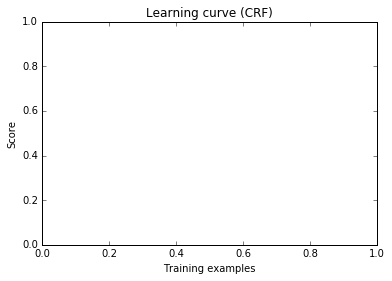

In [55]:
%%time
plot_learning_curve(estimator, title, X, y, scorer, cv = 4, n_jobs=3)
plt.show()

# Hyper-parameter optimization

In [ ]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(t.X_train, t.y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fmambrini/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/fmambrini/anaconda/lib